In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [154]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pylab as plt
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier, MLPRegressor

import copy

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Slides**

Basics

Intuition

Architectures:
    
    MLP
    
    Conv
    
    RNN
    
    LSTM/GRUs
    
    Attention
    
    Transformers
    
Optimization

Theoretical Results


-----
**Notebook**

Toy problems
    
    (DONE) Classification -> Add all 10 plots
    
    (DONE) Regression
    
Real problems

    MNIST
    
    MNIST + Convnet
    
    MNIST + autoencoder (MLP)
    
    MNIST + autoencoder (convnet)
    
RNN toy problems

    Linear trend + noise
    
    Quadratic trend + noise
    
    LSTM/GRUs for same problems
    
RNN Autoencoder

    What data?
    
Pytorch + Torchvision


# Goals of this notebook

We want to introduce the basics of neural networks and deep learning. Modern deep learning is a huge field and it's impossible to cover even all the significant developments in the last 5 years here. But the basics are straightforward.

One big caveat: deep learning is a rapidly evolving field. There are new developments in neural network architectures, novel applications, better optimization techniques, theoretical results justifying why something works etc. daily. It's a great opportunity to get involved if you find research interesting and there are great online communities (pytorch, fast.ai, paperswithcode, pysyft) that you should get involved with.

**Note**: Unlike the previous notebooks, this notebook has very few/no questions. You should study the code, tweak the data, the parameters, and poke the models to understand what's going on.

## Synthetic/Artificial Datasets

We covered the basics of neural networks in the lecture. We also saw applications to two synthetic datasets. The goal in this section is to replicate those results and get a feel for using pytorch.

### Classification

In [4]:
def generate_binary_data(N_examples=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    features = []
    target = []

    for i in range(N_examples):
        #class = 0
        r = np.random.uniform()
        theta = np.random.uniform(0, 2*np.pi)

        features.append([r*np.cos(theta), r*np.sin(theta)])
        target.append(0)

        #class = 1
        r = 3 + np.random.uniform()
        theta = np.random.uniform(0, 2*np.pi)

        features.append([r*np.cos(theta), r*np.sin(theta)])
        target.append(1)

    features = np.array(features)
    target = np.array(target)

    return features, target    

In [5]:
features, target = generate_binary_data(seed=100)

In [6]:
def plot_binary_data(features, target):
    plt.figure(figsize=(10,10))
    plt.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='0')
    plt.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='1')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

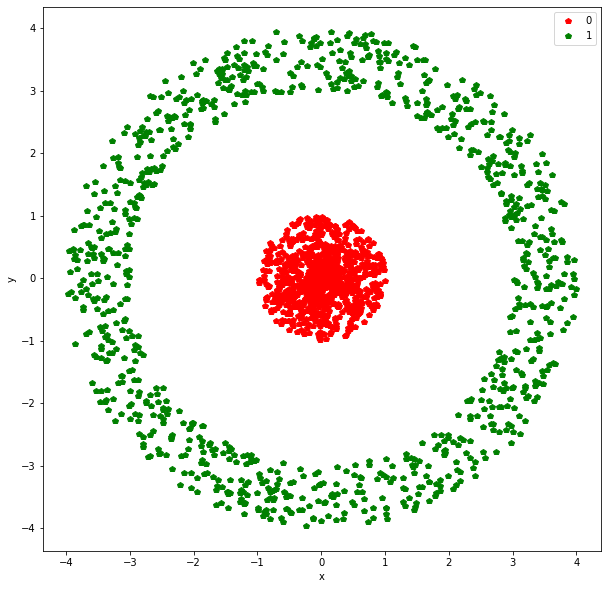

In [7]:
plot_binary_data(features, target)

We have two features here - x and y. There is a binary target variable that we need to predict. This is essentially the dataset during the logistic regression discussion. Logistic regression will not do well here given that the data is not linearly separable. Transforming the data so we have two features:

$$r^2  = x^2 + y^2$$

and

$$\theta = \arctan(\frac{y}{x})$$

would make it very easy to use logistic regression (or just a cut at $r = 2$) to separate the two classes but while it is easy for us to visualize the data and guess at the transformation, in high dimensions, we can't follow the same process.

Let's implement a feed-forward neural network that takes the two features as input and predicts the probabiliy of being in class 1 as output.

#### Architecture Definition

In [8]:
class ClassifierNet(nn.Module): #inherit from nn.Module to define your own architecture
    def __init__(self, N_inputs, N_outputs, N_hidden_layers, N_hidden_nodes, activation, output_activation):
        super(ClassifierNet, self).__init__()
        
        self.N_inputs = N_inputs #2 in our case
        self.N_outputs = N_outputs #1 in our case but can be higher for multi-class classification
        
        self.N_hidden_layers = N_hidden_layers #we'll start by using one hidden layer
        self.N_hidden_nodes = N_hidden_nodes #number of nodes in each hidden layer - can extend to passing a list
        
        #Define layers below - pytorch has a lot of layers pre-defined
        
        #use nn.ModuleList or nn.DictList instead of [] or {} - more explanations below
        self.layer_list = nn.ModuleList([]) #use just as a python list
        for n in range(N_hidden_layers):
            if n==0:
                self.layer_list.append(nn.Linear(N_inputs, N_hidden_nodes))
            else:
                self.layer_list.append(nn.Linear(N_hidden_nodes, N_hidden_nodes))
        
        self.output_layer = nn.Linear(N_hidden_nodes, N_outputs)
        
        self.activation = activation #activations at inner nodes
        self.output_activation = output_activation #activation at last layer (depends on your problem)
        
    def forward(self, inp):
        '''
        every neural net in pytorch has its own forward function
        this function defines how data flows through the architecture from input to output i.e. the forward propagation part
        '''
        
        out = inp
        for layer in self.layer_list:
            out = layer(out) #calls forward function for each layer (already implemented for us)
            out = self.activation(out) #non-linear activation
            
        #pass activations through last/output layer
        out = self.output_layer(out)
        if self.output_activation is not None:
            pred = self.output_activation(out)
        else:
            pred = out
        
        return pred

There are several ways of specifying a neural net architecture in pytorch. You can work at a high level of abstraction by just listing the layers that you want to getting into the fine details by constructing your own layers (as classes) that can be used in ClassifierNet above.

How does pytorch work? When you define an architecture like the one above, pytorch constructs a graph (nodes and edges) where the nodes are operations on 

In [9]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 2
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

#### Training

**Loss function**

We first need to pick our loss function. Like we binary classification problems (including logistic regression), we'll use binary cross-entropy:

$$\text{Loss, } L = -\Sigma_{i=1}^{N} y_i \log(p_i) + (1-y_i) \log(1-p_i)$$

where $y_i \in {0,1}$ are the labels and $p_i \in [0,1]$ are the probability predictions.

In [10]:
#look at all available losses (you can always write your own)
torch.nn.*Loss?

In [11]:
criterion = nn.BCELoss()

In [12]:
#target = 1 (label = 1)
print(criterion(torch.tensor(1e-2), torch.tensor(1.))) #pred prob = 1e-2 -> BAD
print(criterion(torch.tensor(0.3), torch.tensor(1.))) #pred prob = 0.3 -> BAd
print(criterion(torch.tensor(0.5), torch.tensor(1.))) #pred prob = 0.5 -> Bad
print(criterion(torch.tensor(1.), torch.tensor(1.))) #pred prob = 1.0 -> GREAT!

tensor(4.6052)
tensor(1.2040)
tensor(0.6931)
tensor(0.)


**Optimizer**:

So we have the data, the neural net architecture, a loss function to measure how well the model does on our task. We also need a way to do gradient descent.

Recall, we use gradient descent to minimize the loss by computing the first derivative (gradients) and taking a step in the direction opposite (since we are minimizing) to the gradient:

$$w_{t} \rightarrow w_{t} - \eta \frac{\partial L}{\partial w_{t-1}}$$

where $w_t$ = weight at time-step t, $L$ = loss, $\eta$ = learning rate.

For our neural network, we first need to calculate the gradients. Thankfully, this is done automatically by pytorch using a procedure called **backpropagation**. If you are interested in more calculations details, please check "automatic differentiation" and an analytical calculation for a feed-forward network (https://treeinrandomforest.github.io/deep-learning/2018/10/30/backpropagation.html).

The gradients are calculated by calling a function **backward** on the network, as we'll see below.

Once the gradients are calculated, we need to update the weights. In practice, there are many heuristics/variants of the update step above that lead to better optimization behavior. A great resource to dive into details is https://ruder.io/optimizing-gradient-descent/. We won't get into the details here.

We'll choose what's called the **Adam** optimizer.

In [13]:
optim.*?

In [14]:
optimizer = optim.Adam(net.parameters(), lr=1e-2)

We picked a constant learning rate here (which is adjusted internally by Adam) and also passed all the tunable weights in the network by using: net.parameters()

In [15]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.0602, -0.1531],
         [ 0.1022,  0.6350]], requires_grad=True), Parameter containing:
 tensor([-0.1501,  0.3610], requires_grad=True), Parameter containing:
 tensor([[0.6047, 0.6574]], requires_grad=True), Parameter containing:
 tensor([0.6475], requires_grad=True)]

There are 9 free parameters:

* A 2x2 matrix (4 parameters) mapping the input layer to the 1 hidden layer.

* A 2x1 matrix (2 parameters) mapping the hidden layer to the output layer with one node.

* 2 biases for the 2 nodes in the hidden layer.

* 1 bias for the output node in the output layer.


This is a good place to explain why we need to use nn.ModuleList. If we had just used a vanilla python list, net.parameters() would only show weights that are explicitly defined in our net architecture. The weights and biases associated with the layers would NOT show up in net.parameters(). This process of a module higher up in the hierarchy (ClassifierNet) subsuming the weights and biases of modules lower in the hierarchy (layers) is called **registering**. ModuleList ensures that all the weights/biases are registered as weights and biases of ClassifierNet.

Let's combine all these elements and train our first neural net.

In [16]:
#convert features and target to torch tensors
features = torch.from_numpy(features)
target = torch.from_numpy(target)

In [17]:
#if have gpu, throw the model, features and labels on it
net = net.to(device)
features = features.to(device).float()
target = target.to(device).float()

We need to do the following steps now:

* Compute the gradients for our dataset.

* Do gradient descent and update the weights.

* Repeat till ??

The problem is there's no way of knowing when we have converged or are close to the minimum of the loss function. In practice, this means we keep repeating the process above and monitor the loss as well as performance on a hold-out set. When we start over-fitting on the training set, we stop. There are various modifications to this procedure but this is the essence of what we are doing.

Each pass through the whole dataset is called an **epoch**.

In [18]:
N_epochs = 100
for epoch in range(N_epochs):
    out = net(features) #make predictions on the inputs
    loss = criterion(out, target) #compute loss on our predictions
    
    optimizer.zero_grad() #set all gradients to 0
    loss.backward() #backprop to compute gradients
    optimizer.step() #update the weights
    
    if epoch % 10 == 0:
        print(f'Loss = {loss:.4f}')

Loss = 0.8977
Loss = 0.8345
Loss = 0.7851
Loss = 0.7492
Loss = 0.7250
Loss = 0.7098
Loss = 0.7010
Loss = 0.6960
Loss = 0.6933
Loss = 0.6917


/home/sanjay/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Let's combined all these elements into a function

In [19]:
def train_model(features, target, model, lr, N_epochs, criterion=nn.BCELoss(), shuffle=False):
    #criterion = nn.BCELoss() #binary cross-entropy loss as before
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #Adam optimizer

    #if have gpu, throw the model, features and labels on it
    model = model.to(device)
    features = features.to(device)
    target = target.to(device)

    for epoch in range(N_epochs):
        if shuffle: #should have no effect on gradients in this case
            indices = torch.randperm(len(features))

            features_shuffled = features[indices]
            target_shuffled = target[indices]
        else:
            features_shuffled = features
            target_shuffled = target

        out = model(features_shuffled)
        #out = out.reshape(out.size(0))
        loss = criterion(out, target_shuffled)

        if epoch % 1000 == 0:
            print(f'epoch = {epoch} loss = {loss}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pred = model(features_shuffled).reshape(len(target))
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0

    #print(f'Accuracy = {accuracy}')
        
    model = model.to('cpu')
    features = features.to('cpu')
    target = target.to('cpu')

    return model

**Exercise**: Train the model and vary the number of hidden nodes and see what happens to the loss. Can you explain this behavior? 

In [20]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 1
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

net = train_model(features, target, net, 1e-3, 10000)

epoch = 0 loss = 0.7253620624542236
epoch = 1000 loss = 0.6585681438446045
epoch = 2000 loss = 0.6112128496170044
epoch = 3000 loss = 0.5765389800071716
epoch = 4000 loss = 0.5564140677452087
epoch = 5000 loss = 0.5442255139350891
epoch = 6000 loss = 0.5364260673522949
epoch = 7000 loss = 0.5312047600746155
epoch = 8000 loss = 0.5275870561599731
epoch = 9000 loss = 0.5250123143196106


In [21]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 2
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

net = train_model(features, target, net, 1e-3, 10000)

epoch = 0 loss = 0.725173830986023
epoch = 1000 loss = 0.6396005153656006
epoch = 2000 loss = 0.4584709405899048
epoch = 3000 loss = 0.3566585183143616
epoch = 4000 loss = 0.30446675419807434
epoch = 5000 loss = 0.2755127549171448
epoch = 6000 loss = 0.2588322162628174
epoch = 7000 loss = 0.24896906316280365
epoch = 8000 loss = 0.2429696023464203
epoch = 9000 loss = 0.2392101138830185


In [22]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 3
activation = nn.Sigmoid()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

net = train_model(features, target, net, 1e-3, 10000)

epoch = 0 loss = 0.7255417704582214
epoch = 1000 loss = 0.5733204483985901
epoch = 2000 loss = 0.3577575087547302
epoch = 3000 loss = 0.22481489181518555
epoch = 4000 loss = 0.1499558836221695
epoch = 5000 loss = 0.1037924587726593
epoch = 6000 loss = 0.0731620118021965
epoch = 7000 loss = 0.05215834081172943
epoch = 8000 loss = 0.03746207058429718
epoch = 9000 loss = 0.02704370953142643


There seems to be some "magic" behavior when we increase the number of nodes in the first (and only) hidden layer from 2 to 3. Loss suddenly goes down dramatically. At this stage, we should explore why that's happening.

For every node in the hidden layer, we have a mapping from the input to that node:

$$\sigma(w_1 x + w_2 y + b)$$

where $w_1, w_2, b$ are specific to that hidden node. We can plot the decision line in this case:

$$w_1 x + w_2 y + b = 0$$

Unlike logistic regression, this is not actually a decision line. Points on one side are not classified as 0 and points on the other side as 1 (if the threshold = 0.5). Instead this line should be thought of as one defining a new coordinate-system. Instead of x and y coordinates, every hidden node induces a straight line and a new coordinate, say $\alpha_i$. So if we have 3 hidden nodes, we are mapping the 2-dimensional input space into a 3-dimensional space where the coordinates $\alpha_1, \alpha_2, \alpha_3$ for each point depend on which side of the 3 lines induced as mentioned above, it lies.

In [23]:
params = list(net.parameters())

In [24]:
print(params[0]) #3x2 matrix
print(params[1]) #3 biases

Parameter containing:
tensor([[-2.9108,  3.4996],
        [ 1.6538,  3.8115],
        [-5.0209, -0.5446]], requires_grad=True)
Parameter containing:
tensor([ 6.2252, -5.9547, -6.5975], requires_grad=True)


In [25]:
features = features.detach().cpu().numpy() #detach from pytorch computational graph, bring back to cpu, convert to numpy
target = target.detach().cpu().numpy()

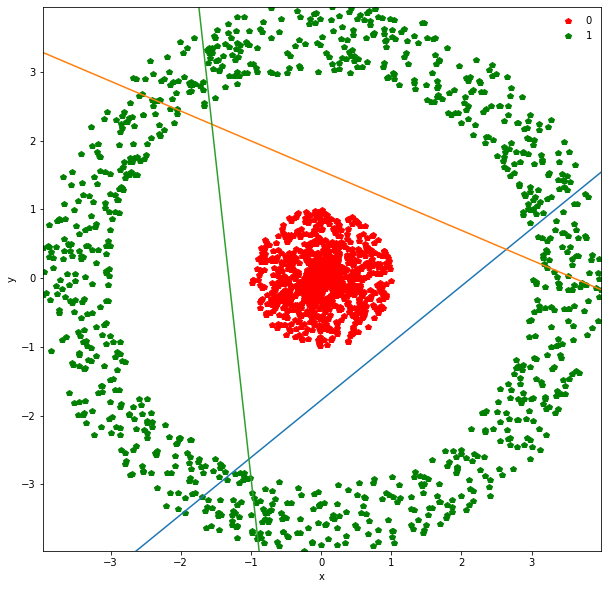

In [26]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot()

#plot raw data
ax.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='0')
ax.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='1')

plt.xlabel('x')
plt.ylabel('y')

#get weights and biases
weights = params[0].detach().numpy()
biases = params[1].detach().numpy()

#plot straight lines
x_min, x_max = features[:,0].min(), features[:,0].max()
y_lim_min, y_lim_max = features[:,1].min(), features[:,1].max()
for i in range(weights.shape[0]): #loop over each hidden node in the one hidden layer
    coef = weights[i]
    intercept = biases[i]
    
    y_min = (-intercept - coef[0]*x_min)/coef[1]
    y_max = (-intercept - coef[0]*x_max)/coef[1]
    
    ax.plot([x_min, x_max], [y_min, y_max])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_lim_min, y_lim_max)
ax.legend(framealpha=0)

This is the plot we showed in the lecture. For every hidden node in the hidden layer, we have a straight line. The colors of the three lines above are orange, green and blue and that's what we'll call our new coordinates.

Suppose you pick a point in the red region:

* It lies to the *right* of the orange line

* It lies to the *bottom* of the green line

* It lies to the *top* of the blue line.

On the other hand, we have **6** green regions. If you start walking clockwise from the top green section, every time you cross a straight line, you walk into a new region. Each time you walk into a new region, you flip the coordinate of one of the 3 lines. Either you go from *right* to *left* of the orange line, *bottom* to *top* of the green line or *top* to *bottom* of the blue line.

So instead of describing each point by two coordinates (x, y), we can describe it by (orange status, green status, blue status). We happen to have 7 such regions here - with 1 being purely occupied by the red points and the other 7 by green points.

This might be become cleared from a 3-dimensional plot.

In [27]:
from mpl_toolkits.mplot3d import Axes3D

In [28]:
#get hidden layer activations for all inputs
features_layer1_3d = net.activation(net.layer_list[0](torch.tensor(features))).detach().numpy()
print(features_layer1_3d[0:10])

[[9.9976999e-01 1.6697874e-02 1.6505669e-03]
 [9.2550421e-05 1.2608622e-06 4.1378937e-07]
 [9.9802786e-01 2.6340880e-03 1.3364932e-03]
 [4.1442123e-05 1.6761838e-07 1.7149123e-06]
 [9.9827743e-01 1.6706572e-03 2.5932428e-03]
 [9.9999988e-01 9.9995565e-01 1.2389904e-06]
 [9.9800354e-01 5.1079681e-03 6.2072393e-04]
 [1.0241896e-02 8.9382894e-02 1.9023681e-10]
 [9.9950874e-01 6.9568053e-02 1.3541241e-04]
 [1.0000000e+00 9.9943250e-01 3.1257400e-03]]


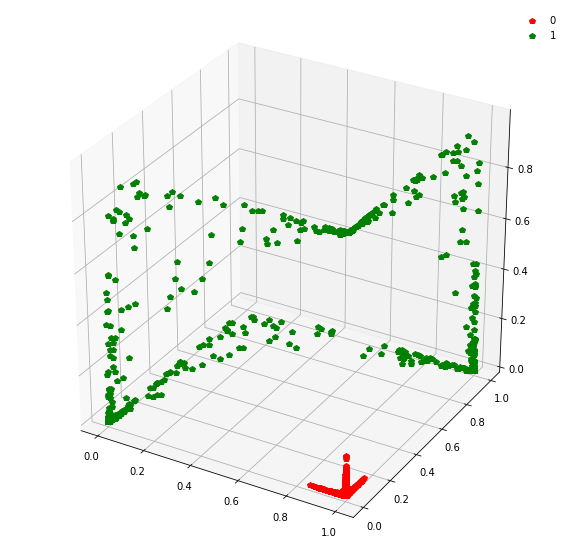

In [29]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

ax.plot(features_layer1_3d[target==0][:,0], features_layer1_3d[target==0][:,1], features_layer1_3d[target==0][:,2], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,0], features_layer1_3d[target==1][:,1], features_layer1_3d[target==1][:,2], 'p', color ='g', label='1')

ax.legend(framealpha=0)

At this stage, a simple linear classifier can draw a linear decision boundary (a plane) to separate the red points from the green points. Also, these points lie in the unit cube (cube with sides of length=1) since we are using sigmoid activations. Whenever the activations get saturated (close to 0 or 1), then we see points on the edges and corners of the cube.

**Question**: Switch the activation from sigmoid to relu (nn.ReLU()). Does the loss still essentially become zero on the train set? If not, try increasing N_hidden_nodes. At what point does the loss actually become close to 0?

In [30]:
N_inputs = 2
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 5
activation = nn.ReLU()
output_activation = nn.Sigmoid() #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

features = torch.tensor(features)
target = torch.tensor(target)

net = train_model(features, target, net, 1e-3, 10000)

epoch = 0 loss = 0.6386891603469849
epoch = 1000 loss = 0.2134970724582672
epoch = 2000 loss = 0.04742448404431343
epoch = 3000 loss = 0.023311790078878403
epoch = 4000 loss = 0.013195257633924484
epoch = 5000 loss = 0.00795586034655571
epoch = 6000 loss = 0.004949876572936773
epoch = 7000 loss = 0.003141082590445876
epoch = 8000 loss = 0.0020185750909149647
epoch = 9000 loss = 0.0013060023775324225


**Question**: Remake the 3d plot but by trying 3 coordinates out of the N_hidden_nodes coordinates you found above?

In [31]:
features = features.detach().cpu().numpy() #detach from pytorch computational graph, bring back to cpu, convert to numpy
target = target.detach().cpu().numpy()

[[ 0.         0.         0.         0.         0.       ]
 [ 6.5895166  0.         0.         5.2662363  0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 7.097395   0.         0.         5.292523   0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.        11.255255 ]
 [ 0.         0.         0.         0.         0.       ]
 [ 3.6289327  0.         0.         4.986752   0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.        10.0527935]]


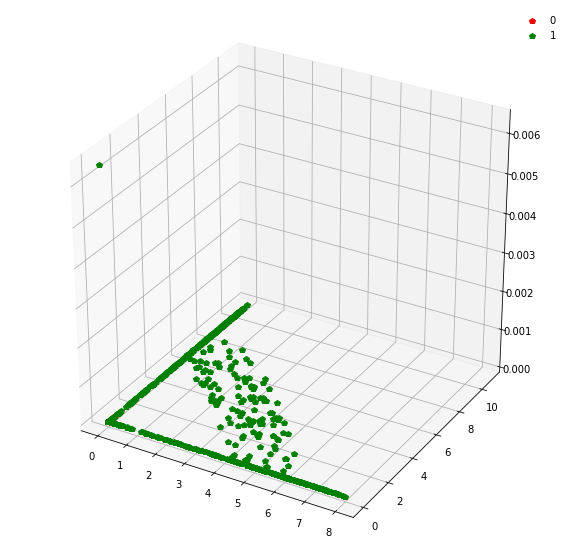

In [32]:
#get hidden layer activations for all inputs
features_layer1_3d = net.activation(net.layer_list[0](torch.tensor(features))).detach().numpy()

print(features_layer1_3d[0:10])

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 0
COORD2 = 1
COORD3 = 2

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

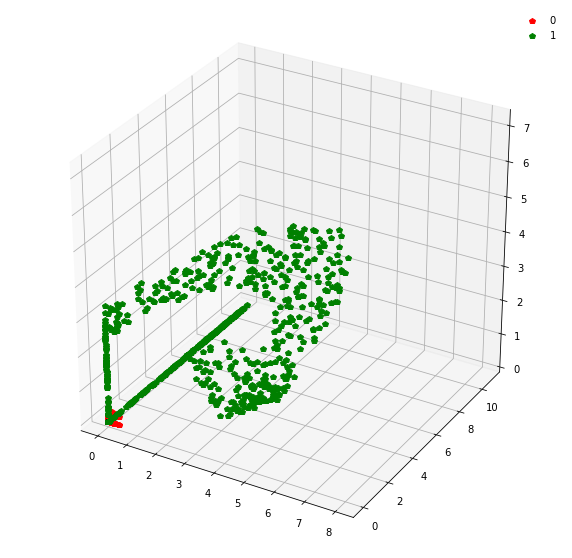

In [33]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 0
COORD2 = 1
COORD3 = 3

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

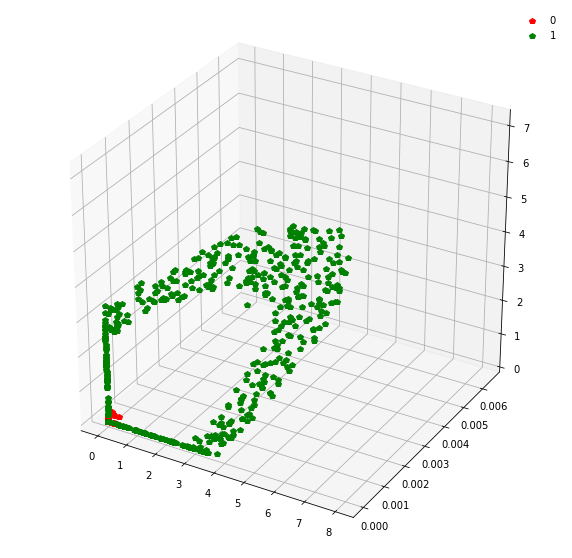

In [34]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 0
COORD2 = 2
COORD3 = 3

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

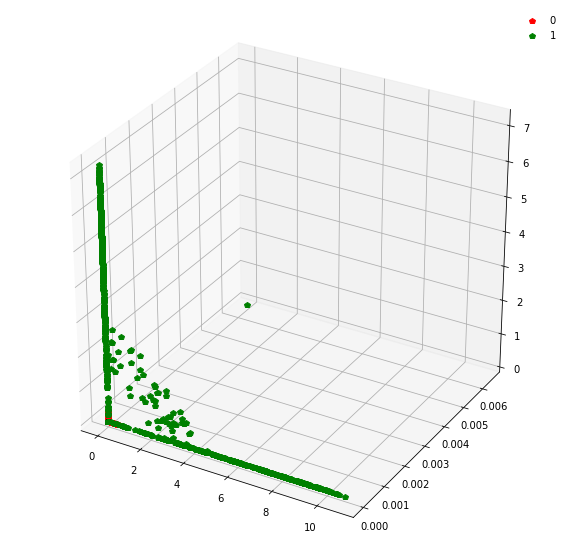

In [35]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d')

COORD1 = 1
COORD2 = 2
COORD3 = 3

ax.plot(features_layer1_3d[target==0][:,COORD1], features_layer1_3d[target==0][:,COORD2], features_layer1_3d[target==0][:,COORD3], 'p', color ='r', label='0')
ax.plot(features_layer1_3d[target==1][:,COORD1], features_layer1_3d[target==1][:,COORD2], features_layer1_3d[target==1][:,COORD3], 'p', color ='g', label='1')

ax.legend(framealpha=0)

**Note**: Generally it is a good idea to use a linear layer for the output layer and use BCEWithLogitsLoss to avoid numerical instabilities.

### Regression

In [36]:
def generate_regression_data(L=10, stepsize=0.1):
    x = np.arange(-L, L, stepsize)
    y = np.sin(3*x) * np.exp(-x / 8.)

    return x, y

def plot_regression_data(x, y):
    plt.figure(figsize=(10,10))
    plt.plot(x, y)
    
    plt.xlabel('x')
    plt.ylabel('y')

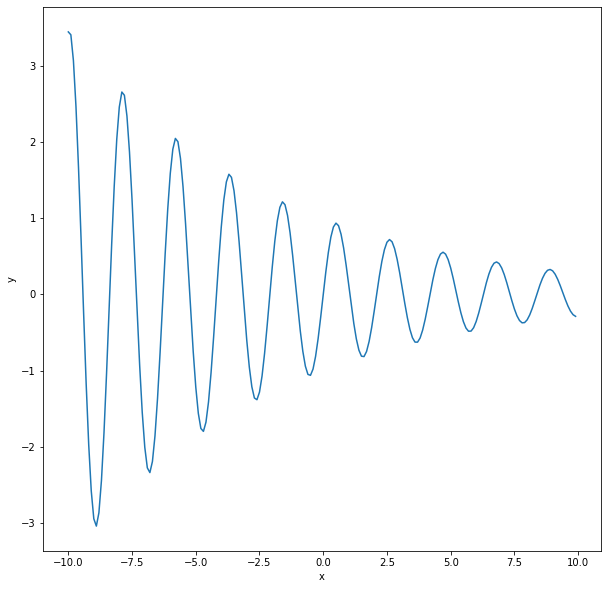

In [37]:
x, y = generate_regression_data()
plot_regression_data(x, y)

This is a pretty different problem in some ways. We now have one input - x and one output - y. But looked at another way, we simply change the number of inputs in our neural network to 1 and we change the output activation to be a linear function. Why linear? Because in principle, the output (y) can be unbounded i.e. any real value.

We also need to change the loss function. While binary cross-entropy is appropriate for a classification problem, we need something else for a regression problem. We'll use mean-squared error:

$$\frac{1}{2}(y_{\text{target}} - y_{\text{pred}})^2$$

In [51]:
N_inputs = 1
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.Sigmoid()
output_activation = None #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

features = torch.tensor(x).float().reshape(len(x), 1)
target = torch.tensor(y).float().reshape(len(y), 1)

In [52]:
net = train_model(features, target, net, 1e-2, 20000, criterion=nn.MSELoss())

epoch = 0 loss = 1.6193264722824097
epoch = 1000 loss = 1.2048382759094238
epoch = 2000 loss = 0.800161600112915
epoch = 3000 loss = 0.22368867695331573
epoch = 4000 loss = 0.12904870510101318
epoch = 5000 loss = 0.12582644820213318
epoch = 6000 loss = 0.12360519170761108
epoch = 7000 loss = 0.10851839929819107
epoch = 8000 loss = 0.10655012726783752
epoch = 9000 loss = 0.10573873668909073
epoch = 10000 loss = 0.10524361580610275
epoch = 11000 loss = 0.10489099472761154
epoch = 12000 loss = 0.10463061928749084
epoch = 13000 loss = 0.10439702868461609
epoch = 14000 loss = 0.10422295331954956
epoch = 15000 loss = 0.10409141331911087
epoch = 16000 loss = 0.10395829379558563
epoch = 17000 loss = 0.10384958982467651
epoch = 18000 loss = 0.10378715395927429
epoch = 19000 loss = 0.10366188734769821


In [82]:
pred = net(features).cpu().detach().numpy().reshape(len(features))

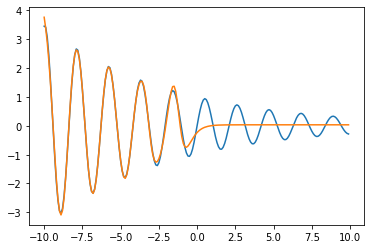

In [83]:
plt.plot(x, y)
plt.plot(x, pred)

As before, we need to understand what the model is doing. As before, let's consider the mapping from the input node to one node of the hidden layer. In this case, we have the mapping:

$$\sigma(w_i x + b_i)$$

where $w_i, b_i$ are the weight and bias associated with each node of the hidden layer. This defines a "decision" boundary where:

$$w_i x + b_i = 0$$

This is just a value $\delta_{i} \equiv -\frac{b_i}{w_i}$. 

For each hidden node $i$, we can calculate one such threshold, $\delta_i$.

As we walk along the x-axis from the left to right, we will cross each threshold one by one. On crossing each threshold, one hidden node switches i.e. goes from $0 \rightarrow 1$ or $1 \rightarrow 0$. What effect does this have on the output or prediction?

Since the last layer is linear, its output is:

$y = v_1 h_1 + v_2 h_2 + \ldots + v_n h_n + c$

where $v_i$ are the weights from the hidden layer to the output node, $c$ is the bias on the output node, and $h_i$ are the activations on the hidden nodes. These activations can smoothly vary between 0 and 1 according to the sigmoid function.

So, when we cross a threshold, one of the $h_j$ values eithers turns off or turns on. This has the effect of adding or subtracting constant $v_k$ values from the output if the kth hidden node, $h_k$ is switching on/off.

This means that as we add more hidden nodes, we can divide the domain (the x values) into more fine-grained intervals that can be assigned a single value by the neural network. In practice, there is a smooth interpolation.

**Question**: Suppose instead of the sigmoid activations, we used a binary threshold:

$$\sigma(x) = \begin{cases}
1 & x > 0 \\
0 & x \leq 0
\end{cases}$$

then we would get a piece-wise constant prediction from our trained network. Plot that piecewise function as a function of $x$.

In [77]:
activations = net.activation(net.layer_list[0](features))
print(activations[0:10])

tensor([[1.0000e+00, 9.9998e-01, 9.1461e-01, 9.9982e-01, 4.8594e-09, 1.0000e+00,
         2.4193e-18, 1.0000e+00, 9.5867e-17, 9.9280e-01],
        [9.9999e-01, 9.9998e-01, 8.8440e-01, 9.9975e-01, 6.8134e-09, 1.0000e+00,
         3.8456e-18, 1.0000e+00, 1.6468e-16, 9.9006e-01],
        [9.9999e-01, 9.9997e-01, 8.4531e-01, 9.9965e-01, 9.5531e-09, 1.0000e+00,
         6.1127e-18, 1.0000e+00, 2.8287e-16, 9.8630e-01],
        [9.9999e-01, 9.9997e-01, 7.9606e-01, 9.9951e-01, 1.3394e-08, 1.0000e+00,
         9.7165e-18, 1.0000e+00, 4.8591e-16, 9.8115e-01],
        [9.9998e-01, 9.9996e-01, 7.3602e-01, 9.9933e-01, 1.8780e-08, 1.0000e+00,
         1.5445e-17, 1.0000e+00, 8.3466e-16, 9.7411e-01],
        [9.9997e-01, 9.9995e-01, 6.6573e-01, 9.9907e-01, 2.6332e-08, 1.0000e+00,
         2.4550e-17, 1.0000e+00, 1.4338e-15, 9.6454e-01],
        [9.9996e-01, 9.9994e-01, 5.8722e-01, 9.9871e-01, 3.6921e-08, 1.0000e+00,
         3.9024e-17, 1.0000e+00, 2.4628e-15, 9.5160e-01],
        [9.9995e-01, 9.9993

In [78]:
binary_activations = nn.Threshold(0.5, 0)(activations)/activations
print(binary_activations[0:10])

tensor([[1., 1., 1., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
        [1., 1., 0., 1., 0., 1., 0., 1., 0., 1.]], grad_fn=<SliceBackward>)


In [79]:
binary_pred = net.output_layer(binary_activations)

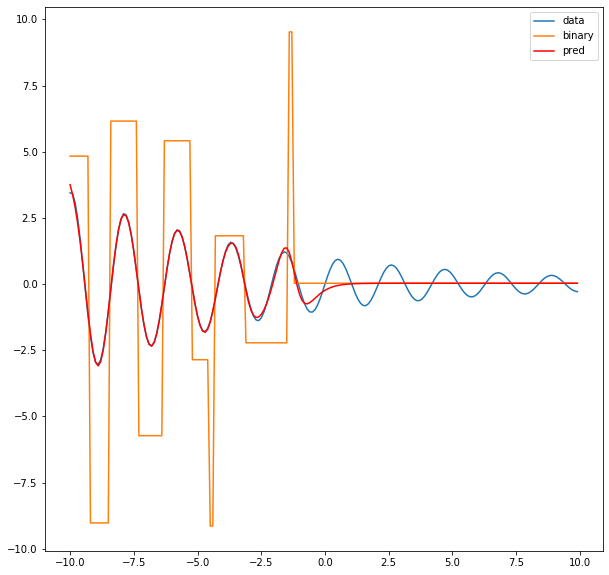

In [87]:
plt.figure(figsize=(10,10))
plt.plot(x,y, label='data')
plt.plot(x, binary_pred.cpu().detach().numpy(), label='binary')
plt.plot(x, pred, color='r', label='pred')
plt.legend()

**Question**: Why does the left part of the function fit so well but the right side is always compromised? Hint: think of the loss function.

The most likely reason is that the loss function is sensitive to the scale of the $y$ values. A 10% deviation between the y-value and the prediction near x = -10 has a larger absolute value than a 10% deviation near say, x = 5.

**Question**: Can you think of ways to test this hypothesis?

There are a couple of things you could do. One is to flip the function from left to right and re-train the model. In this case, the right side should start fitting better.

Another option is to change the loss function to percentage error i.e.:

$$\frac{1}{2} \big(\frac{y_{\text{target}} - y_{\text{pred}}}{y_{\text{target}}}\big)^2$$

but this is probably much harder to optimize.

In [101]:
y = copy.copy(y[::-1])

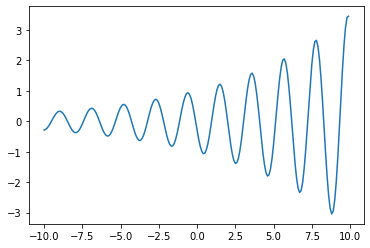

In [102]:
plt.plot(x, y)

In [117]:
N_inputs = 1
N_outputs = 1
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.Sigmoid()
output_activation = None #we want one probability between 0-1

net = ClassifierNet(N_inputs,
                    N_outputs,
                    N_hidden_layers,
                    N_hidden_nodes,
                    activation,
                    output_activation)

features = torch.tensor(x).float().reshape(len(x), 1)
target = torch.tensor(y).float().reshape(len(y), 1)

In [118]:
net = train_model(features, target, net, 1e-2, 14000, criterion=nn.MSELoss())

epoch = 0 loss = 1.6536272764205933
epoch = 1000 loss = 1.2398383617401123
epoch = 2000 loss = 0.9127373695373535
epoch = 3000 loss = 0.41191717982292175
epoch = 4000 loss = 0.28583306074142456
epoch = 5000 loss = 0.27131006121635437
epoch = 6000 loss = 0.26317352056503296
epoch = 7000 loss = 0.2575070261955261
epoch = 8000 loss = 0.24530799686908722
epoch = 9000 loss = 0.1397223025560379
epoch = 10000 loss = 0.11965251713991165
epoch = 11000 loss = 0.1098325178027153
epoch = 12000 loss = 0.10409624129533768
epoch = 13000 loss = 0.1004016101360321


In [119]:
pred = net(features).cpu().detach().numpy().reshape(len(features))

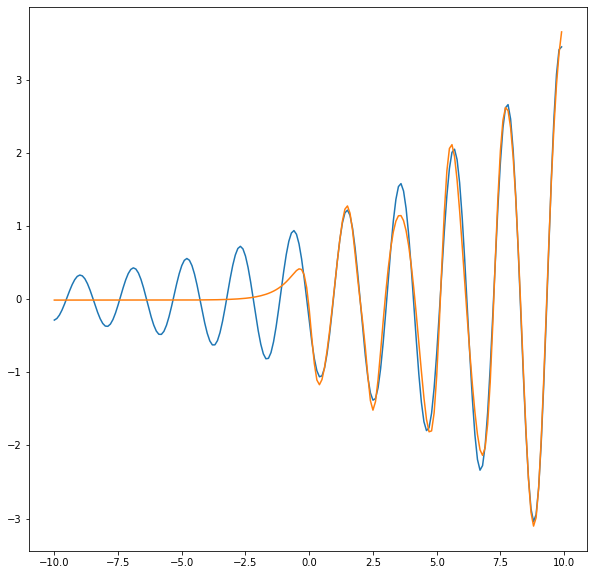

In [120]:
plt.figure(figsize=(10,10))
plt.plot(x, y)
plt.plot(x, pred)

As expected, now the right side of the function fits well.

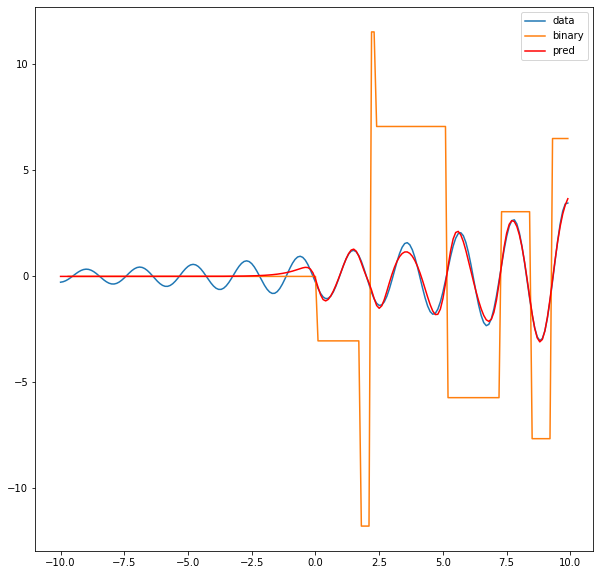

In [121]:
activations = net.activation(net.layer_list[0](features))
binary_activations = nn.Threshold(0.5, 0)(activations)/activations
binary_pred = net.output_layer(binary_activations)

plt.figure(figsize=(10,10))
plt.plot(x,y, label='data')
plt.plot(x, binary_pred.cpu().detach().numpy(), label='binary')
plt.plot(x, pred, color='r', label='pred')
plt.legend()

### Image Classification

One of the most successful applications of deep learning has been to computer vision. A central task of computer vision is **image classification**. This is the task of assigning exactly one of multiple labels to an image. 

pytorch provides a package called **torchvision** which includes datasets, some modern neural network architectures as well as helper functions for images.

In [218]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [124]:
DOWNLOAD_PATH = "../data/MNIST"

In [274]:
mnist_train = MNIST(DOWNLOAD_PATH, 
                    train=True, 
                    download=True,
                    transform = transforms.Compose([transforms.ToTensor()]))

mnist_test = MNIST(DOWNLOAD_PATH, 
                   train=False, 
                   download=True,
                   transform = transforms.Compose([transforms.ToTensor()]))

MNIST is one of the classic image datasets and consists of 28 x 28 pixel images of handwritten digits. We downloaded both the train and test sets. Transforms defined under target_transform will be applied to each example. In this example, we want tensors and not images which is what the transforms do.

The train set consists of 60000 images.

In [241]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [242]:
mnist_train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

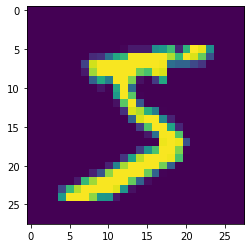

In [243]:
plt.imshow(mnist_train.data[0])

There are 10 unique labels - 0 through 9

In [244]:
mnist_train.targets[0:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

The labels are roughly equally/uniformly distributed

In [245]:
np.unique(mnist_train.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

The test set consists of 10000 images.

In [246]:
mnist_test.data.shape

torch.Size([10000, 28, 28])

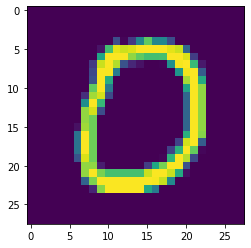

In [247]:
plt.imshow(mnist_test.data[10])

Same labels

In [248]:
mnist_test.targets[0:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

Pretty equally distributed.

In [249]:
np.unique(mnist_test.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

**Image Classifier**:

We first have to pick an architecture. The first one we'll pick is a feed-forward neural network like the one we used in the exercises above. This time I am going to use a higher abstraction to define the network.

In [250]:
#convert 28x28 image -> 784-dimensional flattened vector
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, inp):
        return inp.flatten(start_dim=1, end_dim=2)

In [251]:
Flatten()(mnist_train.data[0:10]).shape

torch.Size([10, 784])

Architecture definition using nn.Sequential. You can just list the layers in a sequence. We carry out the following steps:

* Flatten each image into a 784 dimensional vector

* Map the image to a 100-dimensional vector using a linear layer

* Apply a relu non-linearity

* Map the 100-dimensional vector into a 10-dimensional output layer since we have 10 possible targets.

* Apply a softmax activation to convert the 10 numbers into a probability distribution that assigns the probability the image belonging to each class (0 through 9)

A softmax activation takes N numbers $a_1, \ldots, a_{10}$ and converts them to a probability distribution. The first step is to ensure the numbers are positive (since probabilities cannot be negative). This is done by exponentiation.

$$a_i \rightarrow e^{a_i}$$

The next step is to normalize the numbers i.e. ensure they add up to 1. This is very straightforward. We just divide each score by the sum of scores:

$$p_i = \frac{e^{a_i}}{e^{a_1} + e^{a_2} + \ldots + e^{a_N}}$$

This is the softmax function. If you have done statistical physics (physics of systems with very large number of interacting constituents), you probably have seen the Boltzmann distribution:

$$p_i = \frac{e^{-\beta E_i}}{e^{-\beta E_1} + e^{-\beta E_2} + \ldots + e^{-\beta E_N}}$$

which gives the probability that a system with N energy levels is in the state with energy $i$ when it is in equilibrium with a thermal bath at temperature $T = \frac{1}{k_B\beta}$. This is the only probability distribution that is invariant to constant shifts in energy: $E_i \rightarrow E_i + \Delta$.

In [252]:
image_ff_net = nn.Sequential(Flatten(), 
                             nn.Linear(784, 100),
                             nn.ReLU(),
                             nn.Linear(100, 10),
                             nn.Softmax(dim=1) #convert 10-dim activation to probability distribution
                            )

Let's ensure the data flows through our neural network and check the dimensions.

In [253]:
image_ff_net(mnist_train.data[0:12].float()).shape

torch.Size([12, 10])

We get a 10-dimensional output as expected.

**Question**: Check that the outputs for each image are actually a probability distribution (the numbers add up to 1).

In [254]:
image_ff_net(mnist_train.data[0:10].float()).sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<SumBackward2>)

**Question**: We have an architecture for our neural network but we now need to decide what loss to pick. Unlike the classification problem earlier which had two classes, we have 10 classes here. Take a look at the pytorch documentation - what loss do you think we should pick to model this problem?

We used cross-entropy loss on days 2 and 3. We need the same loss here. Pytorch provides NLLLoss (negative log likelihood) as well as CrossEntropyLoss.

**Question**: Look at the documentation for both of these loss functions. Which one should we pick? Do we need to make any modifications to our architecture?

TODO: add details of log-sum-exp

In [255]:
image_ff_net = nn.Sequential(Flatten(), 
                             nn.Linear(784, 100),
                             nn.ReLU(),
                             nn.Linear(100, 10),
                            )

Now we'll get raw unnormalized scores that were used to compute the probabilities. We should use nn.CrossEntropyLoss in this case.

In [256]:
image_ff_net(mnist_train.data[0:12].float())

tensor([[ 1.1887e+00,  1.5860e+01, -3.2162e+00,  2.3435e+01, -1.1693e+01,
          7.7910e-01, -1.3443e+01,  4.5016e+00, -2.7148e+00,  2.6126e+01],
        [-9.2603e+00, -7.5874e-02, -4.7538e+00,  4.6079e+01, -2.4899e+01,
          1.4317e+01, -1.2428e+01, -1.5265e+01, -1.9441e+01,  2.3587e+01],
        [ 3.9362e+00, -2.7344e+01,  7.4574e+00,  2.0998e+01, -4.4295e+00,
         -1.0711e+01, -1.8448e+01,  1.7588e+01,  1.5646e+01, -1.4789e+01],
        [ 1.9504e+00,  1.7611e+01,  1.0609e+01,  2.5320e+01, -2.4288e+01,
          2.3160e+01,  7.0454e+00,  3.7207e+01,  2.2460e+01,  3.1843e+01],
        [ 1.9489e+00,  1.3590e+01,  1.1894e+01,  4.4759e+01, -3.3674e+01,
         -3.3675e+00, -1.1304e+01,  2.5272e+01, -4.4852e+00,  2.6048e+01],
        [-6.7792e+00,  2.0831e+01,  9.1066e+00,  2.9843e+01, -4.3917e-01,
          1.4325e+01, -2.0658e+01,  1.6390e+01, -4.8549e+00,  6.2113e+00],
        [-7.3337e+00,  2.3017e+01,  2.4574e+00,  1.9896e+01, -2.6133e+01,
          2.6040e+01, -2.9214e+0

In [257]:
loss = nn.CrossEntropyLoss()

**Training**: We have an architecture, the data, an appropriate loss. Now we need to loop over the images, use the loss to compare the predictions to the targets, compute the gradients and update the weights.

In our previous examples, we had N_epoch passes over our dataset and each time, we computed predictions for the full dataset. This is impractical as datasets gets larger. Instead, we need to split the data into **batches** of a fixed size, compute the loss, the gradients and update the weights for each batch.


pytorch provides a DataLoader class that makes it easy to generate batches from your dataset.

**Optional**:

Let's analyze how using batches can be different from using the full dataset. Suppose our data has 10,000 rows but we use batches of size 100 (usually we pick powers of 2 for the GPU but this is just an example). Statistically, our goal is always to compute the gradient:

$$\frac{\partial L}{\partial w_i}$$

for all the weights $w_i$. By weights here, I mean both the weights and biases and any other free or tunable parameters in our model.

In practice, the loss is a sum over all the examples in our dataset:

$$L = \frac{1}{N}\Sigma_{i}^N l(p_i, t_i)$$

where $p_i$ = prediction for ith example, $t_i$ = target/label for ith example. So the derivative is:

$$\frac{\partial L}{\partial w_i} = \frac{1}{N}\Sigma_i^N \frac{\partial l(p_i, t_i)}{\partial w_i} $$

In other words, our goal is to calculate this quantity but $N$ is too large. So we pick a randomly chosen subset of size 100 and only average the gradients over those examples. As an analogy, if our task was to measure the average height of all the people in the world which is impractical, we would pick randomly chosen subsets, say of 10,000 people and measure their average heights. 

Of course, as we make the subset smaller, the estimate we get will be noisier i.e. it has a greater chance of higher deviation from the actual value (height or gradient). Is this good or bad? It depends. In our case, we are optimizing a function (the loss) that has multiple local minima and saddle points. It is easy to get stuck in regions of the loss space/surface. Having noisy gradients can help with escaping those local minima just because we'll not always be moving in the direction of the true gradient but a noisy estimate.

Some commonly used terminology in case you read papers/articles:

* (Full) Gradient Descent - compute the gradients over the full dataset. Memory-intensive for larger datasets.

* Mini-batch Gradient Descent - use randomly chosen samples of fixed size as your data. Noisier gradients, more frequent updates to your model, memory efficient.

* Stochastic Gradient Descent - Mini-batch gradient descent with batch size = 1. Very noisy estimate, "online" updates to your model, can be hard to converge.

There are some fascinating papers on more theoretical investigations into the loss surface and the behavior of gradient descent. Here are some examples:

* https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf

* https://arxiv.org/abs/1811.03804

* https://arxiv.org/pdf/1904.06963.pdf


**End of optional section**


In [307]:
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(mnist_train, 
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, #shuffle data
                                               num_workers=8,
                                               pin_memory=True
                                             )
test_dataloader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, #shuffle data
                                              num_workers=8,
                                              pin_memory=True
                                             )

In [308]:
train_examples = enumerate(train_dataloader)

In [309]:
idx, (data_example, target_example) = next(train_examples)

In [310]:
print(idx)
print(data_example.shape)
print(target_example.shape)

0
torch.Size([64, 1, 28, 28])
torch.Size([64])


So we have batch 0 with 64 tensors of shape (1, 28, 28) and 64 targets. Let's ensure our network can forward propagate on this batch.

In [293]:
image_ff_net(data_example)

RuntimeError: size mismatch, m1: [1792 x 28], m2: [784 x 100] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:961

**Question**: Debug this error

The first shape 1792 x 28 gives us a clue. We want the two 28 sized dimensions to be flattened. But it seems like the wrong dimensions are being flattened here.

1792 = 64 * 28

We need to rewrite our flatten layer.

In [304]:
#convert 28x28 image -> 784-dimensional flattened vector
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, inp):
        return inp.flatten(start_dim=1, end_dim=-1)

In [311]:
Flatten()(data_example).shape

torch.Size([64, 784])

In [312]:
image_ff_net = nn.Sequential(Flatten(), 
                             nn.Linear(784, 100),
                             nn.ReLU(),
                             nn.Linear(100, 10),
                            )

In [314]:
image_ff_net(data_example).shape

torch.Size([64, 10])

Let's combine all the elements together now and write our training loop.

In [336]:
#convert 28x28 image -> 784-dimensional flattened vector
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, inp):
        return inp.flatten(start_dim=1, end_dim=-1)
    
#ARCHITECTURE
image_ff_net = nn.Sequential(Flatten(), 
                             nn.Linear(784, 100),
                             nn.ReLU(),
                             nn.Linear(100, 10),
                            )

#LOSS CRITERION and OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_ff_net.parameters(), lr=1e-2)


#DATALOADERS
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(mnist_train, 
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, #shuffle data
                                               num_workers=8,
                                               pin_memory=True
                                             )
test_dataloader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, #shuffle data
                                              num_workers=8,
                                              pin_memory=True
                                             )

In [337]:
image_ff_net.train() #don't worry about this (for this notebook)
image_ff_net.to(device)

N_EPOCHS = 20
for epoch in range(N_EPOCHS):
    loss_list = []
    for idx, (data_example, data_target) in enumerate(train_dataloader):
        data_example = data_example.to(device)
        data_target = data_target.to(device)
        
        pred = image_ff_net(data_example)

        loss = criterion(pred, data_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        
    if epoch % 5 == 0:        
        print(f'Epoch = {epoch} Loss = {np.mean(loss_list)}')

Epoch = 0 Loss = 0.22780211882661783
Epoch = 5 Loss = 0.0852861228371178
Epoch = 10 Loss = 0.06776682103424073
Epoch = 15 Loss = 0.06049105984969005


**Question**: Use your trained network to compute the accuracy on both the train and test sets.

In [339]:
image_ff_net = image_ff_net.eval() #don't worry about this (for this notebook)

We'll use argmax to extract the label with the highest probability (or the least negative raw score).

In [343]:
image_ff_net(data_example).argmax(dim=1)

tensor([5, 5, 8, 7, 8, 6, 9, 5, 4, 9, 6, 6, 1, 4, 7, 2, 3, 4, 4, 4, 1, 5, 9, 4,
        5, 5, 4, 8, 9, 6, 0, 8], device='cuda:0')

In [354]:
train_pred, train_targets = torch.tensor([]), torch.tensor([])
with torch.no_grad(): #context manager for inference since we don't need the memory footprint of gradients
    for idx, (data_example, data_target) in enumerate(train_dataloader):
        data_example = data_example.to(device)
        
        #make predictions
        label_pred = image_ff_net(data_example).argmax(dim=1).float()
        
        #concat and store both predictions and targets
        label_pred = label_pred.to('cpu')
        train_pred = torch.cat((train_pred, label_pred))
        train_targets = torch.cat((train_targets, data_target.float()))

In [356]:
train_pred[0:10]

tensor([4., 2., 6., 8., 0., 2., 3., 5., 3., 4.])

In [357]:
train_targets[0:10]

tensor([4., 2., 6., 8., 0., 2., 3., 5., 3., 4.])

In [371]:
torch.sum(train_pred == train_targets).item() / train_pred.shape[0]

0.9890666666666666

In [370]:
train_pred.shape[0]

60000

In [373]:
assert(train_pred.shape == train_targets.shape)
train_accuracy = torch.sum(train_pred == train_targets).item() / train_pred.shape[0]
print(f'Train Accuracy = {train_accuracy:.4f}')

Train Accuracy = 0.9891


Here, I want to make an elementary remark about significant figures. While interpreting numbers like accuracy, it is important to realize how big your dataset and what impact flipping one example from a wrong prediction to the right prediction would have.

In our case, the train set has 60,000 examples. Suppose we were to flip one of the incorrectly predicted examples to a correct one (by changing the model, retraining etc etc.). This should change our accuracy, all other examples being the same, by 

$$\frac{1}{60,000} = 1.66 * 10^{-5}$$

Any digits in the accuracy beyond the fifth place have no meaning! For our test set, we have 10,000 examples so we should only care at most about the 4th decimal place (10,000 being a "nice" number i.e. a power of 10 will ensure we never have more any way).

In [379]:
test_pred, test_targets = torch.tensor([]), torch.tensor([])
with torch.no_grad(): #context manager for inference since we don't need the memory footprint of gradients
    for idx, (data_example, data_target) in enumerate(test_dataloader):
        data_example = data_example.to(device)
        
        #make predictions
        label_pred = image_ff_net(data_example).argmax(dim=1).float()
        
        #concat and store both predictions and targets
        label_pred = label_pred.to('cpu')
        test_pred = torch.cat((test_pred, label_pred))
        test_targets = torch.cat((test_targets, data_target.float()))

In [380]:
assert(test_pred.shape == test_targets.shape)
test_accuracy = torch.sum(test_pred == test_targets).item() / test_pred.shape[0]
print(f'Test  Accuracy = {test_accuracy:.4f}')

Test  Accuracy = 0.9689


Great! so our simple neural network already does a great job on our task. At this stage, we would do several things:

* Look at the examples being classified incorrectly. Are these bad data examples? Would a person also have trouble classifying them?

* Test stability - what happens if we rotate images? Translate them? Flip symmetric digits? What happens if we add some random noise to the pixel values?

While we might add these to future iterations of this notebook, let's move on to some other architectural choices. One of the issues with flattening the input image is that of **locality**. Images have a notion of locality. If a pixel contains part of an object, its neighboring pixels are very likely to contain the same object. But when we flatten an image, we use all the pixels to map to each hidden node in the next layer. If we could impose locality by changing our layers, we might get much better performance.

In addition, we would like image classification to be invariant to certain transformations like translation (move the digit up/down, left/right), scaling (zoom in and out without cropping the image), rotations (at least upto some angular width). Can we impose any of these by our choice of layers?

The answer is yes! Convolutional layers are layers designed specifically to capture such locality and preserve translational invariance. There is a lot of material available describing what these are and we won't repeat it here. Instead, we'll repeat the training procedure above but with convolutional layers.

TODO: Add analysis of incorrectly predicted examples

TODO (for future iteration): add a notebook for image filters, convolutions etc.

Let's try a convolutional layer:

nn.Conv2d

which takes in the number of input channels (grayscale), number of output channels (we'll choose 20), kernel size (3x3) and run the transformations on some images.

In [384]:
train_examples = enumerate(train_dataloader)
idx, (data_example, target_example) = next(train_examples)

In [387]:
print(data_example.shape)
print(nn.Conv2d(1, 20, 3)(data_example).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 20, 26, 26])


**Question**: If you do know what convolutions are and how filters work, justify these shapes.

The first dimension is the batch size which remains unchanged, as expected. In the raw data, the second dimension is the number of channels i.e. grayscale only and the last two dimensions are the size of the image - 28x28.

We choose 20 channels which explains the output's second dimension. Each filter is 3x3 and since we have no padding, it can only process 26 patches in each dimension.

If we label the pixels along the columns as 1, 2, ..., 28, the patch can be applied from pixels 1-3 (inclusive of both end-points), 2-5, ..., 26-28. After that, the patch "falls off" the image unless we apply some padding. This explains the dimension 26 in both directions.

We can then apply a ReLU activation to all these activations.

In [391]:
nn.ReLU()((nn.Conv2d(1, 20, 3)(data_example)))

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

We should also apply some kind of pooling or averaging now. This reduces noise by picking disjoint, consecutive patches on the image and replacing them by some aggregate statistic like max or mean.

In [395]:
nn.MaxPool2d(kernel_size=2)(nn.ReLU()((nn.Conv2d(1, 20, 3)(data_example)))).shape

torch.Size([64, 20, 13, 13])

**A couple of notes**:

* Pytorch's functions like nn.ReLU() and nn.MaxPool2d() return functions that can apply operations. That's why we have been 

In [ ]:
#ARCHITECTURE
image_conv_net = nn.Sequential(nn.Conv2d(1, 20, 3),
                               nn.ReLU(),
                               nn.Linear(100, 10),
                            )

#LOSS CRITERION and OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_ff_net.parameters(), lr=1e-2)


#DATALOADERS
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(mnist_train, 
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True, #shuffle data
                                               num_workers=8,
                                               pin_memory=True
                                             )
test_dataloader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, #shuffle data
                                              num_workers=8,
                                              pin_memory=True
                                             )